<a href="https://colab.research.google.com/github/jangvu/Project_by_me/blob/main/resnet_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial


In [2]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        print("---")
        print(inputs)
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


  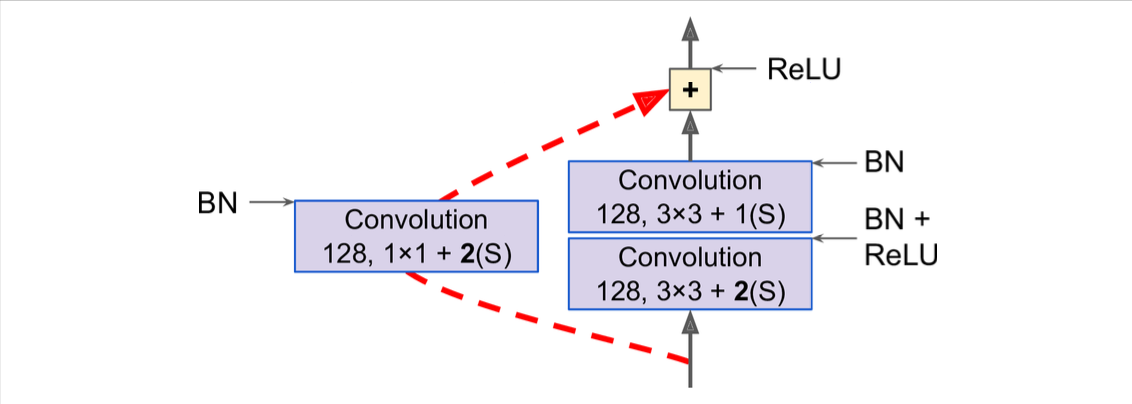

In [3]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    print(filters)
    strides = 1 if filters == prev_filters else 2
    a = ResidualUnit(filters, strides=strides)
    print(a)
    model.add(ResidualUnit(filters, strides=strides))

    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))


64
---
Tensor("Placeholder:0", shape=(None, 8, 8, 64), dtype=float32)
64
---
Tensor("Placeholder:0", shape=(None, 8, 8, 64), dtype=float32)
64
---
Tensor("Placeholder:0", shape=(None, 8, 8, 64), dtype=float32)
128
---
Tensor("Placeholder:0", shape=(None, 8, 8, 64), dtype=float32)
128
---
Tensor("Placeholder:0", shape=(None, 4, 4, 128), dtype=float32)
128
---
Tensor("Placeholder:0", shape=(None, 4, 4, 128), dtype=float32)
128
---
Tensor("Placeholder:0", shape=(None, 4, 4, 128), dtype=float32)
256
---
Tensor("Placeholder:0", shape=(None, 4, 4, 128), dtype=float32)
256
---
Tensor("Placeholder:0", shape=(None, 2, 2, 256), dtype=float32)
256
---
Tensor("Placeholder:0", shape=(None, 2, 2, 256), dtype=float32)
256
---
Tensor("Placeholder:0", shape=(None, 2, 2, 256), dtype=float32)
256
---
Tensor("Placeholder:0", shape=(None, 2, 2, 256), dtype=float32)
256
---
Tensor("Placeholder:0", shape=(None, 2, 2, 256), dtype=float32)
512
---
Tensor("Placeholder:0", shape=(None, 2, 2, 256), dtype=float32)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 8, 8, 64)          74240     
_________________________________________________________________
residual_unit_5 (ResidualUni (None, 8, 8, 64)          7

In [5]:
(X_train_full,y_train_full),(X_test,y_test) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 6s 0us/step


In [6]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(y_train_full.reshape(-1))+1))
labels = label_binarizer.transform(y_train_full)
X_train,X_valid = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_train,y_valid = labels[:5000], labels[5000:]
print(X_train.shape)
print(y_train.shape)
y_train[0]

(5000, 32, 32, 3)
(5000, 10)


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',metrics='accuracy')
early_stopping = keras.callbacks.EarlyStopping(patience= 5, monitor='loss')
#model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor = 'loss', save_best_only=True)
callbacks = [early_stopping]
optimizers = keras.optimizers.Adam(learning_rate= 0.001)


In [21]:
history = model.fit(X_train,y_train,epochs = 100, validation_data=(X_valid,y_valid), callbacks=[callbacks])

Epoch 1/100
---
Tensor("sequential/max_pooling2d/MaxPool:0", shape=(None, 8, 8, 64), dtype=float32)
---
Tensor("sequential/residual_unit_1/Relu_1:0", shape=(None, 8, 8, 64), dtype=float32)
---
Tensor("sequential/residual_unit_3/Relu_1:0", shape=(None, 8, 8, 64), dtype=float32)
---
Tensor("sequential/residual_unit_5/Relu_1:0", shape=(None, 8, 8, 64), dtype=float32)
---
Tensor("sequential/residual_unit_7/Relu_1:0", shape=(None, 4, 4, 128), dtype=float32)
---
Tensor("sequential/residual_unit_9/Relu_1:0", shape=(None, 4, 4, 128), dtype=float32)
---
Tensor("sequential/residual_unit_11/Relu_1:0", shape=(None, 4, 4, 128), dtype=float32)
---
Tensor("sequential/residual_unit_13/Relu_1:0", shape=(None, 4, 4, 128), dtype=float32)
---
Tensor("sequential/residual_unit_15/Relu_1:0", shape=(None, 2, 2, 256), dtype=float32)
---
Tensor("sequential/residual_unit_17/Relu_1:0", shape=(None, 2, 2, 256), dtype=float32)
---
Tensor("sequential/residual_unit_19/Relu_1:0", shape=(None, 2, 2, 256), dtype=float32

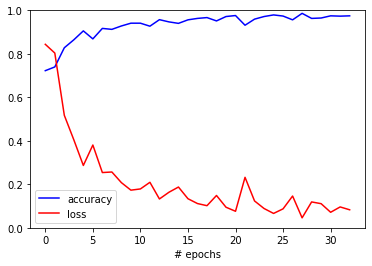

In [27]:
import matplotlib.pyplot as plt
plt.ylim(0,1)
plt.xlabel('# epochs')
#plt.xlim(0,1)
plt.plot(history.history['accuracy'], 'b', label = 'accuracy')
plt.plot(history.history['loss'], 'r', label = 'loss')
plt.legend()
plt.show()

